## REI602M Machine Learning - Project 1
### Due: *Friday* 20.04.2018

**Objectives**: Allstate Claims Severity

**Name**: Þór Tómasarson, **email: ** tht33@hi.is, **collaborators:** Eggert Jón Magnússon

In [3]:
import time
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format

# %matplotlib notebook
import seaborn as sns
sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

### Preprocess the data

In [2]:
train = pd.read_csv('train.csv', delimiter=',', index_col='id')
X_train, y_train = train.loc[:, train.columns != 'loss'], train['loss']

In [3]:
# Split train - test
#X_train = pd.get_dummies(X_train, drop_first=True) # Sometimes useful to start with this 

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.30)
X_train_origin, y_train_origin = X_train.copy(), y_train.copy()

X_train.describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,...,cat116_P,cat116_Q,cat116_R,cat116_S,cat116_T,cat116_U,cat116_V,cat116_W,cat116_X,cat116_Y
count,"131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000",...,"131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000"
mean,0.493,0.508,0.499,0.492,0.487,0.491,0.485,0.486,0.485,0.498,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
std,0.188,0.207,0.202,0.211,0.209,0.205,0.178,0.199,0.182,0.186,...,0.000,0.004,0.005,0.004,0.000,0.009,0.000,0.003,0.004,0.007
min,0.000,0.001,0.003,0.177,0.281,0.013,0.070,0.237,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.345,0.358,0.337,0.327,0.281,0.336,0.350,0.313,0.359,0.365,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.476,0.556,0.528,0.453,0.422,0.441,0.439,0.441,0.437,0.461,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.624,0.682,0.634,0.652,0.635,0.655,0.591,0.624,0.562,0.615,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,0.985,0.863,0.944,0.952,0.984,0.997,1.000,0.980,0.995,0.995,...,0.000,1.000,1.000,1.000,0.000,1.000,0.000,1.000,1.000,1.000


No need to transform any of the continuous attributes. They are all on the interval [0, 1] with reasonable standard deviation, also there are no missing values for the continuous attributes.

The **loss** column has the following statistics {mean: 3037.3, std: 2904.1, min: 0.67, max: 121012.25}. With $min\approx0$, $mean \approx std$ and $max>>std$ $\frac{max}{std}=\frac{121012.25}{2904.1}=41.67$, these numbers indicate a highly skewed data with long tail to the right.

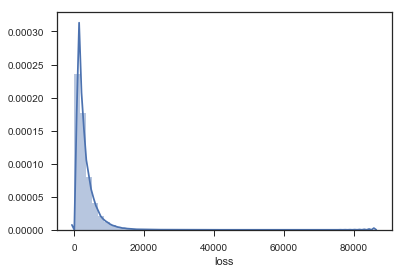

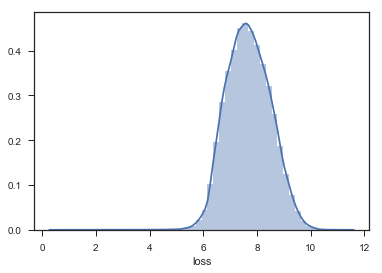

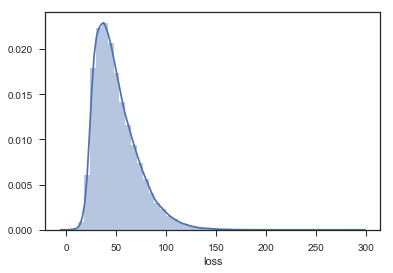

In [76]:
sns.distplot(y_train)
plt.show()

sns.distplot(np.log1p(y_train))
plt.show()

In [191]:
# y_train = np.log1p(y_train)

The former plot confirms the theory of skewness. With a $log(x + 1)$ transform the **loss** column looks more like the expected (at least for Linear Regression) Gaussian distribution. The $+1$ in $log(x + 1)$ is just to be on the safe side of the floating point cancellation, even though the data indicates that there should not be a need for it (with min $0.67 >> 0$ "in some sense").

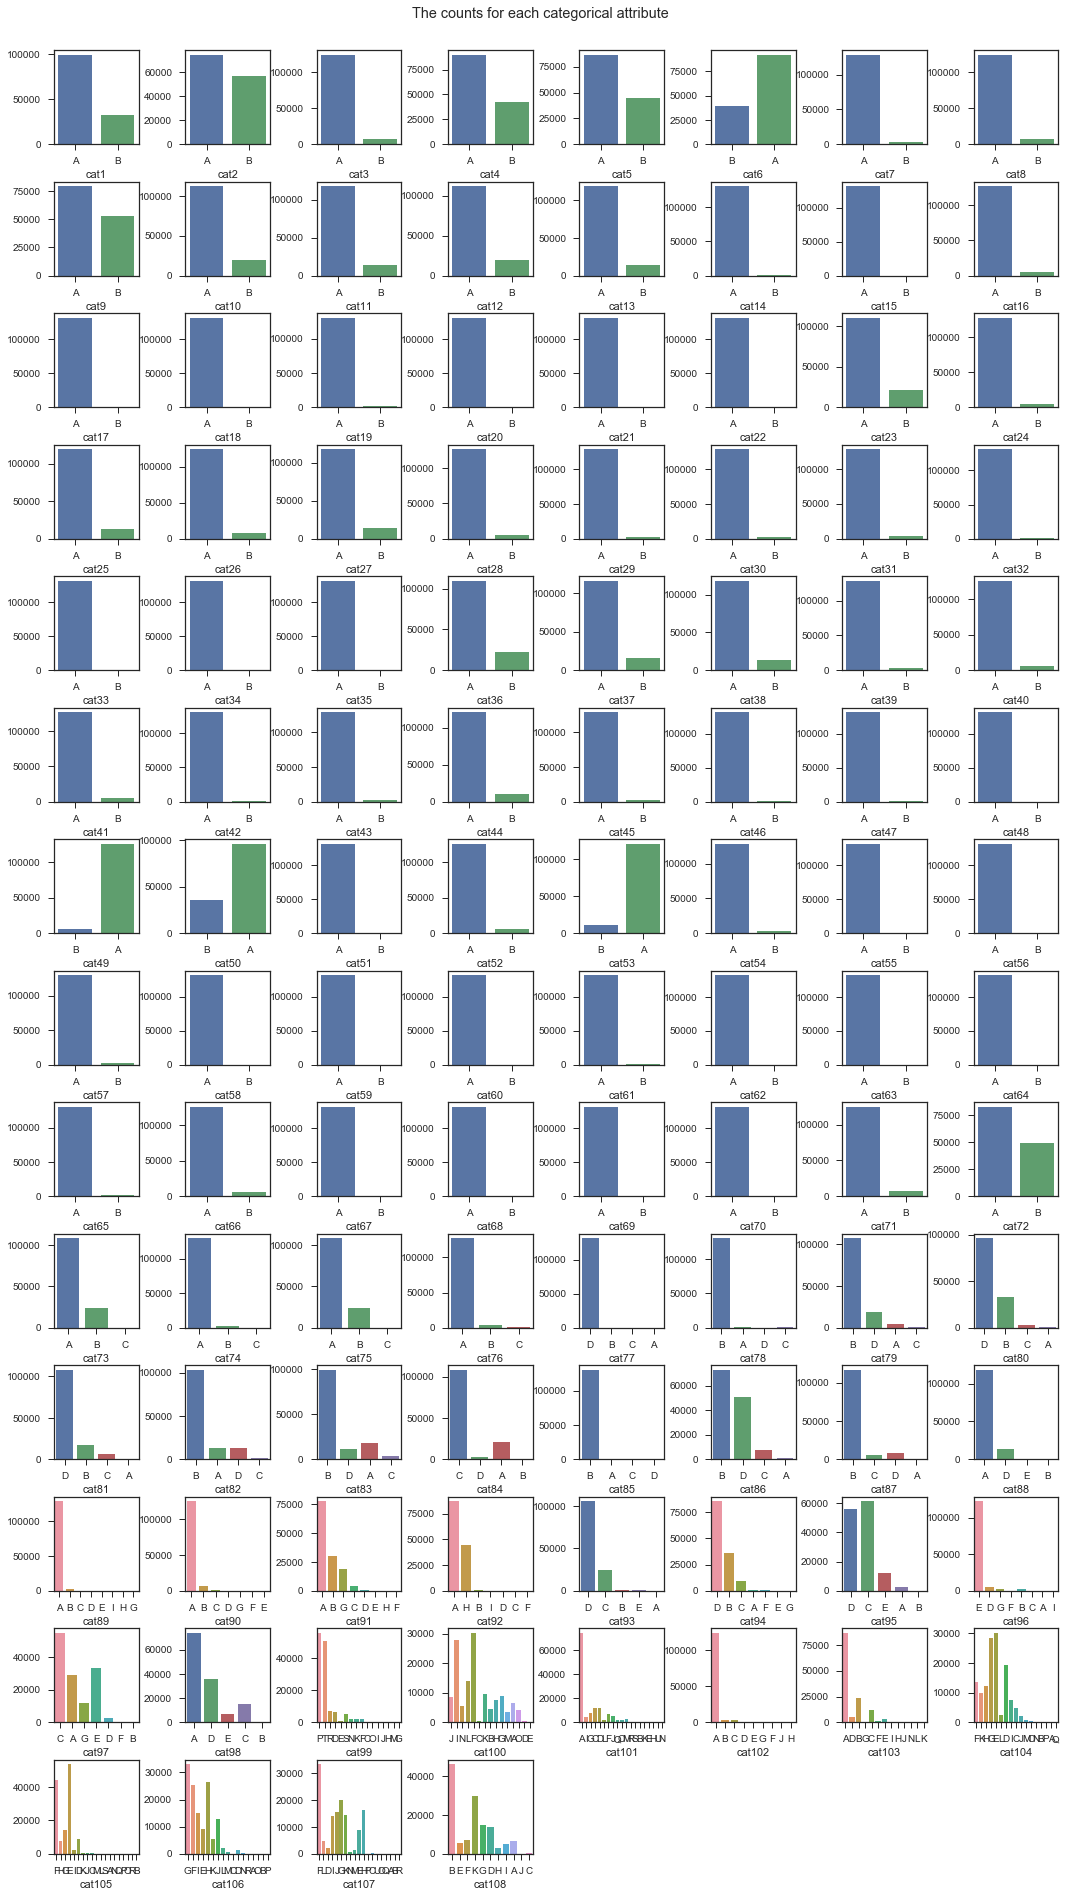

In [5]:
# Count the number of items for each categorical attribute
cat_index = [x for x in X_train.columns if x.startswith('cat')]
X_train[cat_index].describe(include = 'all')

n = 8
r = len(cat_index)//n
plt.figure(figsize=(18, 30))
for i in range(r):
    for j in range(n if i != r-1
                     else ((len(cat_index)%n))
                  ):
        plot = plt.subplot(r, n, (i*n + j + 1))
        # sns.boxplot(x=features[axIndex], y="loss", data=train_data, ax=axList[axIndex])
        ax = sns.countplot(x=cat_index[i*n + j], data=X_train)
        plt.subplots_adjust(wspace=0.55, hspace=0.4, top=0.96)
        ax.set_ylabel('')
plt.suptitle('The counts for each categorical attribute')
plt.show()

There are few categorical attributes that have next to no distribution, that is to say all values have the same label except very few. These few items could be a rare event but they could also be "uninteresting" and then consequently will increase the number of attributes without the need for it, which could damage the performance for some of the models. In order to be able to distinguish between whether these are rare events or "uninteresting" then we would need to know the true nature of these attributes (would need have the field knowledge).

Since we can not know what these attributes represent then for safety measures we keep them all when performing the one-hot encoding.

In [6]:
# One-hot transform
X_train = pd.get_dummies(X_train, drop_first=True)

# # drop_first is crucial to avoid correlation in these features
# # See this example:
# df = pd.DataFrame(data={'Sex': ['M', 'F', 'F', 'B'], 'Married': ['Yes', 'Yes', 'No', 'No']})
# pd.get_dummies(df, drop_first=True) # VS. drop_first=false

Correlations:
      cont1  cont10  cont11  cont12  cont13  cont14  cont2  cont3  cont4  \
loss -0.009   0.018   0.098   0.097  -0.003   0.020  0.140  0.110 -0.038   

      cont5  cont6  cont7  cont8  cont9  
loss -0.011  0.041  0.118  0.030  0.016  


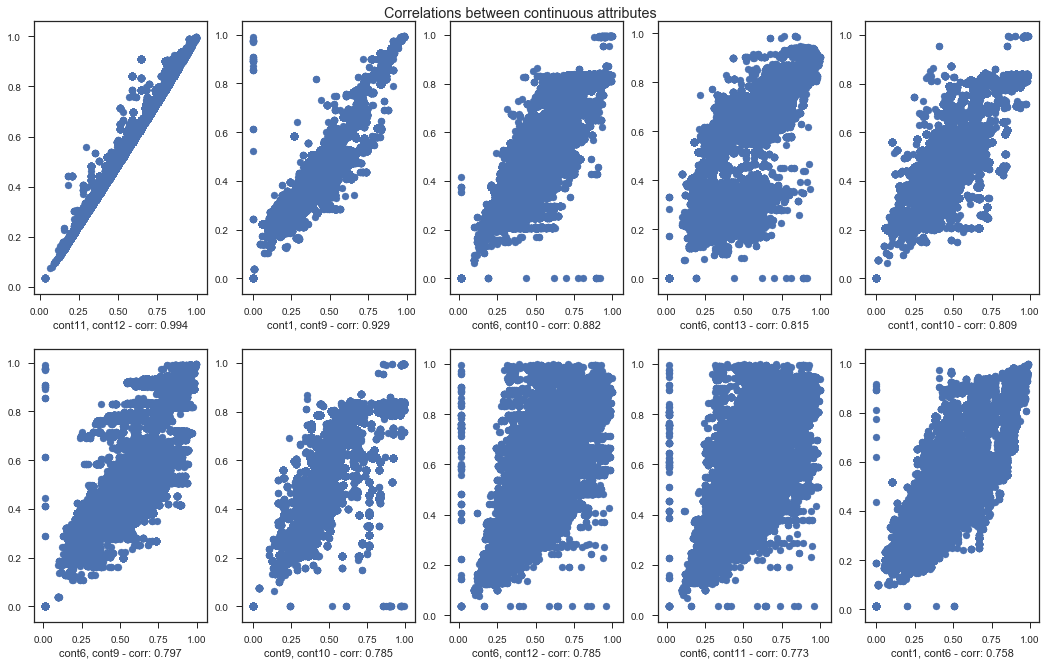


There are 10 correlated features with (absolute) correlation higher than 0.75


In [7]:
cont_index = lambda : [x for x in X_train.columns if x.startswith('cont')]

print('Correlations:')
corr = {}
corr_cont_loss = {}
for idx, col_1 in enumerate(cont_index()):
    corr[(col_1, 'loss')] = X_train[col_1].corr(y_train)
    corr_cont_loss[col_1] = corr[(col_1, 'loss')]
    
    for col_2 in cont_index()[idx+1:]:
        if col_1 != col_2:
            corr[(col_1, col_2)] = X_train[col_1].corr(X_train[col_2])
print(pd.DataFrame(data=corr_cont_loss, index=['loss']))
            
limit = 0.75
correlated = {}
for key, value in corr.items():
    if np.abs(value) > limit:
        correlated[key] = value

import operator
correlated = sorted(correlated.items(), key=operator.itemgetter(1))
correlated.reverse()

plt.figure(figsize=(18, 10))
i = 0
for key, value in correlated:
    plot = plt.subplot(2, 5, i + 1)
    plt.scatter(X_train[key[0]], X_train[key[1]]) # Nota alpha-blending (hue)
    # ax = sns.jointplot(x=key[0], y=key[1], data=X_train)
    plot.set_xlabel(f'{key[0]}, {key[1]} - corr: {value:.3f}')
    plt.subplots_adjust(top=0.96)
    i += 1
plt.suptitle('Correlations between continuous attributes')
plt.show()

print(f'\nThere are {len(correlated)} correlated features with (absolute) correlation higher than {limit}')

There is no single continuous attribute with high correlation with the output (loss - attribute).

There are 10 correlated pairs (correlation > 0.75) out of the 14x14 combinations of the continuous attributes. The correlation is high and visible for {cont1-cont9, cont6-cont10, cont1-cont10, cont6-cont9, cont9-cont10, cont1-cont6} and extremely high for {cont11-cont12}. This indicates that PCA could be very useful, or one could even consider dropping the following attributes {cont12, cont6, cont9, cont10}. Thus reducing the number of continuous attributes down to 10 attributes.

In [4]:
X_train.drop(['cont12', 'cont6', 'cont9', 'cont10'], axis=1, inplace=True)
X_test.drop(['cont12', 'cont6', 'cont9', 'cont10'], axis=1, inplace=True)

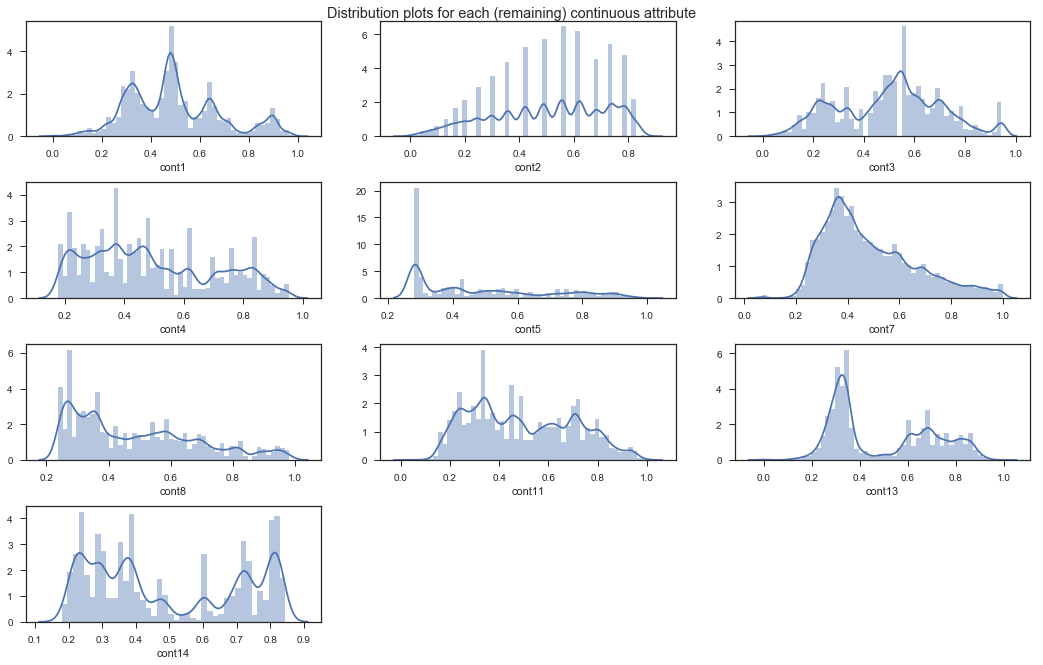

In [9]:
plt.figure(figsize=(18, 10))

n = len(cont_index())
for i, col in enumerate(cont_index()):
    plot = plt.subplot(n//3+1, 3, i + 1)
    sns.distplot(X_train[col])
    plot.set_xlabel(f'{col}')
    plt.subplots_adjust(hspace=0.4, top=0.96)
plt.suptitle('Distribution plots for each (remaining) continuous attribute')
plt.show()

Most of these continuous attributes look a bit discreet, it might be worth validating that these are indeed interval or ratio numbers (not just ordinal).

In [5]:
# TOOD: Apply the same function on both the test and train datasets
def preprocess_data(X, y):
    pass

# X_train_changed = X_train.copy()
# X_train, y_train = preprocess_data(X_train_origin, y_train_origin)
# assert X_train == X_train_changed

# X_test, y_test = preprocess_data(X_test, y_test)
n_train, m_train = X_train.shape
n_test, m_test = X_test.shape

In [194]:
# Fit estimators
ESTIMATORS = {
    # Linear: (Run with PCA (or PCA->30->t-SNE) and non-negative)
    "LinearRegression": LinearRegression(n_jobs=-1),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001), # Try Elastic-Net með tveimur stikum
    # non-linear
    "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=1, n_jobs=-1),
    "SVR": SVR(),
    "BaggingRegressor": BaggingRegressor(n_jobs=-1),
    "RandomForestRegressor": RandomForestRegressor(n_jobs=-1, n_estimators=50),
    "ExtraTreesRegressor": ExtraTreesRegressor(n_jobs=-1, n_estimators=100),
} # Relu og dropout

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    t_0 = time.time()
    print(f'{name}:')
    estimator.fit(X_train, y_train)
    
    t_1 = time.time()
    print(f'\tTime elapsed for fitting of model {t_1 - t_0:.3f} sec')
    y_test_predict[name] = estimator.predict(X_test)
    error = mean_absolute_error(y_test, y_test_predict[name]) # TODO: Add np.expm1(..
    print(f'\tTime elapsed for prediction {time.time() - t_1:.3f} sec')
    print(f'\tError: {error:.3f}')
    
# This here is with no log-transform

LinearRegression:
	Time elapsed for fitting of model 24.355 sec
	Time elapsed for prediction 0.434 sec
	Error: 1655603234.882
Ridge:
	Time elapsed for fitting of model 5.799 sec
	Time elapsed for prediction 0.414 sec
	Error: 1302.587
Lasso:


C:\Users\Notandi\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


	Time elapsed for fitting of model 200.994 sec
	Time elapsed for prediction 0.426 sec
	Error: 1305.573
KNeighborsRegressor:
	Time elapsed for fitting of model 95.604 sec
	Time elapsed for prediction 4662.196 sec
	Error: 1747.104
SVR:
	Time elapsed for fitting of model 20007.080 sec
	Time elapsed for prediction 10160.075 sec
	Error: 1755.613
BaggingRegressor:
	Time elapsed for fitting of model 134.787 sec
	Time elapsed for prediction 12.849 sec
	Error: 1295.292
RandomForestRegressor:
	Time elapsed for fitting of model 475.075 sec
	Time elapsed for prediction 1.643 sec
	Error: 1245.477
ExtraTreesRegressor:
	Time elapsed for fitting of model 1922.238 sec
	Time elapsed for prediction 3.084 sec
	Error: 1281.961


In [ ]:
import sys

print("GradientBoostingRegressor")
t_0 = time.time()
y_test_predict = dict()
for n in [5, 50, 250, 500, 1000]:
    for a in [0.9, 0.5, 0.1]:
        for lr in [0.1, 0.0001]:
            for sl in [10, 20]:
                for ss in [10, 20]:
                    for md in [2, 3, 6]:
                        try:
                            estimator = GradientBoostingRegressor(loss='huber', alpha=a,
                                                    n_estimators=n, max_depth=md,
                                                    learning_rate=lr, min_samples_leaf=sl,
                                                    min_samples_split=ss)
                            t_1 = time.time()
                            name = f"loss='huber', alpha={a}, n_estimators={n}, max_depth={md}, \
learning_rate={lr}, min_samples_leaf={sl}, min_samples_split={ss}"
                            print(f"{name}")
                            estimator.fit(X_train, y_train)

                            t_2 = time.time()
                            print(f'\tTime elapsed for fitting of model {t_2 - t_1:.3f} sec')
                            y_test_predict[name] = estimator.predict(X_test)
                            error = mean_absolute_error(y_test, y_test_predict[name])
                            print(f'\tTime elapsed for prediction {time.time() - t_2:.3f} sec')
                            print(f'\tError: {error:.3f}')
                        except:
                            print("Unexpected error:", sys.exc_info())

GradientBoostingRegressor
loss='huber', alpha=0.9, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10
	Time elapsed for fitting of model 19.163 sec
	Time elapsed for prediction 0.624 sec
	Error: 1617.870
loss='huber', alpha=0.9, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10
	Time elapsed for fitting of model 27.251 sec
	Time elapsed for prediction 0.655 sec
	Error: 1587.853
loss='huber', alpha=0.9, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10
	Time elapsed for fitting of model 77.914 sec
	Time elapsed for prediction 0.660 sec
	Error: 1532.987
loss='huber', alpha=0.9, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20
	Time elapsed for fitting of model 17.980 sec
	Time elapsed for prediction 0.614 sec
	Error: 1617.870
loss='huber', alpha=0.9, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_

	Time elapsed for prediction 0.720 sec
	Error: 1350.012
loss='huber', alpha=0.9, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10
	Time elapsed for fitting of model 182.526 sec
	Time elapsed for prediction 0.761 sec
	Error: 1290.901
loss='huber', alpha=0.9, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10
	Time elapsed for fitting of model 608.373 sec
	Time elapsed for prediction 0.861 sec
	Error: 1210.449
loss='huber', alpha=0.9, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20
	Time elapsed for fitting of model 101.775 sec
	Time elapsed for prediction 0.736 sec
	Error: 1350.012
loss='huber', alpha=0.9, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20
	Time elapsed for fitting of model 182.924 sec
	Time elapsed for prediction 0.760 sec
	Error: 1290.901
loss='huber', alpha=0.9, n_estimators=50, max_depth=6, learning_rate

	Time elapsed for prediction 1.093 sec
	Error: 1223.694
loss='huber', alpha=0.9, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10
	Time elapsed for fitting of model 761.545 sec
	Time elapsed for prediction 1.253 sec
	Error: 1190.403
loss='huber', alpha=0.9, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10
	Time elapsed for fitting of model 2204.041 sec
	Time elapsed for prediction 1.733 sec
	Error: 1165.056
loss='huber', alpha=0.9, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20
	Time elapsed for fitting of model 430.569 sec
	Time elapsed for prediction 1.077 sec
	Error: 1223.694
loss='huber', alpha=0.9, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20
	Time elapsed for fitting of model 761.087 sec
	Time elapsed for prediction 1.279 sec
	Error: 1190.403
loss='huber', alpha=0.9, n_estimators=250, max_depth=6, learnin

	Time elapsed for prediction 1.646 sec
	Error: 1202.341
loss='huber', alpha=0.9, n_estimators=500, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10
	Time elapsed for fitting of model 1553.904 sec
	Time elapsed for prediction 2.016 sec
	Error: 1177.162
loss='huber', alpha=0.9, n_estimators=500, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10
	Time elapsed for fitting of model 4215.218 sec
	Time elapsed for prediction 2.967 sec
	Error: 1162.143
loss='huber', alpha=0.9, n_estimators=500, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20
	Time elapsed for fitting of model 904.808 sec
	Time elapsed for prediction 1.651 sec
	Error: 1202.341
loss='huber', alpha=0.9, n_estimators=500, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20
	Time elapsed for fitting of model 1551.806 sec
	Time elapsed for prediction 2.000 sec
	Error: 1177.176
loss='huber', alpha=0.9, n_estimators=500, max_depth=6, learn

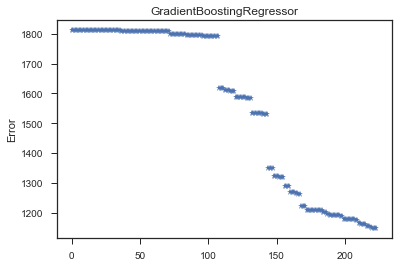

loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20
	Error: 1149.09
loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10
	Error: 1149.125
loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10
	Error: 1149.238
loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20
	Error: 1150.382
loss='huber', alpha=0.1, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10
	Error: 1153.54
loss='huber', alpha=0.1, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20
	Error: 1154.371
loss='huber', alpha=0.1, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10
	Error: 1155.83
loss='huber', alpha=0.1, n_estimators=250, max_depth=6, learning_

In [17]:
gradient_boosting_error = {"loss='huber', alpha=0.9, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1617.870, "loss='huber', alpha=0.9, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1587.853, "loss='huber', alpha=0.9, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1532.987, "loss='huber', alpha=0.9, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1617.870, "loss='huber', alpha=0.9, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1587.853, "loss='huber', alpha=0.9, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1532.987, "loss='huber', alpha=0.9, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1617.870, "loss='huber', alpha=0.9, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1587.853, "loss='huber', alpha=0.9, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1532.679, "loss='huber', alpha=0.9, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1617.870, "loss='huber', alpha=0.9, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1587.853, "loss='huber', alpha=0.9, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1532.679, "loss='huber', alpha=0.9, n_estimators=5, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1811.795, "loss='huber', alpha=0.9, n_estimators=5, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1811.762, "loss='huber', alpha=0.9, n_estimators=5, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1811.692, "loss='huber', alpha=0.9, n_estimators=5, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1811.795, "loss='huber', alpha=0.9, n_estimators=5, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1811.762, "loss='huber', alpha=0.9, n_estimators=5, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1811.692, "loss='huber', alpha=0.9, n_estimators=5, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1811.795, "loss='huber', alpha=0.9, n_estimators=5, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1811.762, "loss='huber', alpha=0.9, n_estimators=5, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1811.692, "loss='huber', alpha=0.9, n_estimators=5, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1811.795, "loss='huber', alpha=0.9, n_estimators=5, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1811.762, "loss='huber', alpha=0.9, n_estimators=5, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1811.692, "loss='huber', alpha=0.5, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1612.133, "loss='huber', alpha=0.5, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1587.346, "loss='huber', alpha=0.5, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1535.546, "loss='huber', alpha=0.5, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1612.133, "loss='huber', alpha=0.5, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1587.346, "loss='huber', alpha=0.5, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1535.546, "loss='huber', alpha=0.5, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1612.133, "loss='huber', alpha=0.5, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1587.346, "loss='huber', alpha=0.5, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1535.529, "loss='huber', alpha=0.5, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1612.133, "loss='huber', alpha=0.5, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1587.346, "loss='huber', alpha=0.5, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1535.529, "loss='huber', alpha=0.5, n_estimators=5, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1811.808, "loss='huber', alpha=0.5, n_estimators=5, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1811.768, "loss='huber', alpha=0.5, n_estimators=5, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1811.711, "loss='huber', alpha=0.5, n_estimators=5, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1811.808, "loss='huber', alpha=0.5, n_estimators=5, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1811.768, "loss='huber', alpha=0.5, n_estimators=5, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1811.711, "loss='huber', alpha=0.5, n_estimators=5, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1811.808, "loss='huber', alpha=0.5, n_estimators=5, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1811.768, "loss='huber', alpha=0.5, n_estimators=5, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1811.711, "loss='huber', alpha=0.5, n_estimators=5, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1811.808, "loss='huber', alpha=0.5, n_estimators=5, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1811.768, "loss='huber', alpha=0.5, n_estimators=5, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1811.711, "loss='huber', alpha=0.1, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1609.175, "loss='huber', alpha=0.1, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1583.347, "loss='huber', alpha=0.1, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1533.252, "loss='huber', alpha=0.1, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1609.175, "loss='huber', alpha=0.1, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1583.347, "loss='huber', alpha=0.1, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1533.252, "loss='huber', alpha=0.1, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1609.175, "loss='huber', alpha=0.1, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1583.347, "loss='huber', alpha=0.1, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1531.789, "loss='huber', alpha=0.1, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1609.175, "loss='huber', alpha=0.1, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1583.347, "loss='huber', alpha=0.1, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1531.789, "loss='huber', alpha=0.1, n_estimators=5, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1811.805, "loss='huber', alpha=0.1, n_estimators=5, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1811.770, "loss='huber', alpha=0.1, n_estimators=5, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1811.706, "loss='huber', alpha=0.1, n_estimators=5, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1811.805, "loss='huber', alpha=0.1, n_estimators=5, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1811.770, "loss='huber', alpha=0.1, n_estimators=5, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1811.706, "loss='huber', alpha=0.1, n_estimators=5, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1811.805, "loss='huber', alpha=0.1, n_estimators=5, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1811.770, "loss='huber', alpha=0.1, n_estimators=5, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1811.707, "loss='huber', alpha=0.1, n_estimators=5, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1811.805, "loss='huber', alpha=0.1, n_estimators=5, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1811.770, "loss='huber', alpha=0.1, n_estimators=5, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1811.707, "loss='huber', alpha=0.9, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1350.012, "loss='huber', alpha=0.9, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1290.901, "loss='huber', alpha=0.9, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1210.449, "loss='huber', alpha=0.9, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1350.012, "loss='huber', alpha=0.9, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1290.901, "loss='huber', alpha=0.9, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1210.439,
                           "loss='huber', alpha=0.9, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1350.012, "loss='huber', alpha=0.9, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1290.965, "loss='huber', alpha=0.9, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1209.183, "loss='huber', alpha=0.9, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1350.012, "loss='huber', alpha=0.9, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1290.965, "loss='huber', alpha=0.9, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1209.185, "loss='huber', alpha=0.9, n_estimators=50, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1809.154, "loss='huber', alpha=0.9, n_estimators=50, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1808.822, "loss='huber', alpha=0.9, n_estimators=50, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1808.126, "loss='huber', alpha=0.9, n_estimators=50, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1809.154, "loss='huber', alpha=0.9, n_estimators=50, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1808.822, "loss='huber', alpha=0.9, n_estimators=50, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1808.126, "loss='huber', alpha=0.9, n_estimators=50, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1809.154, "loss='huber', alpha=0.9, n_estimators=50, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1808.822, "loss='huber', alpha=0.9, n_estimators=50, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1808.126, "loss='huber', alpha=0.9, n_estimators=50, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1809.154, "loss='huber', alpha=0.9, n_estimators=50, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1808.822, "loss='huber', alpha=0.9, n_estimators=50, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1808.126, "loss='huber', alpha=0.5, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1322.774, "loss='huber', alpha=0.5, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1268.964, "loss='huber', alpha=0.5, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1192.706, "loss='huber', alpha=0.5, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1322.774, "loss='huber', alpha=0.5, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1268.964, "loss='huber', alpha=0.5, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1193.041, "loss='huber', alpha=0.5, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1322.774, "loss='huber', alpha=0.5, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1267.985, "loss='huber', alpha=0.5, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1193.603, "loss='huber', alpha=0.5, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1322.774, "loss='huber', alpha=0.5, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1267.985, "loss='huber', alpha=0.5, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1193.603, "loss='huber', alpha=0.5, n_estimators=50, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1809.283, "loss='huber', alpha=0.5, n_estimators=50, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1808.882, "loss='huber', alpha=0.5, n_estimators=50, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1808.309, "loss='huber', alpha=0.5, n_estimators=50, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1809.283, "loss='huber', alpha=0.5, n_estimators=50, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1808.882, "loss='huber', alpha=0.5, n_estimators=50, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1808.309, "loss='huber', alpha=0.5, n_estimators=50, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1809.283, "loss='huber', alpha=0.5, n_estimators=50, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1808.882, "loss='huber', alpha=0.5, n_estimators=50, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1808.309, "loss='huber', alpha=0.5, n_estimators=50, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1809.283, "loss='huber', alpha=0.5, n_estimators=50, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1808.882, "loss='huber', alpha=0.5, n_estimators=50, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1808.309, "loss='huber', alpha=0.1, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1319.222, "loss='huber', alpha=0.1, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1264.335, "loss='huber', alpha=0.1, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1195.187, "loss='huber', alpha=0.1, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1319.222, "loss='huber', alpha=0.1, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1264.335, "loss='huber', alpha=0.1, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1195.280, "loss='huber', alpha=0.1, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1319.222, "loss='huber', alpha=0.1, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1265.041, "loss='huber', alpha=0.1, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1193.988, "loss='huber', alpha=0.1, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1319.222, "loss='huber', alpha=0.1, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1265.041, "loss='huber', alpha=0.1, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1193.598, "loss='huber', alpha=0.1, n_estimators=50, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1809.230, "loss='huber', alpha=0.1, n_estimators=50, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1808.894, "loss='huber', alpha=0.1, n_estimators=50, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1808.268, "loss='huber', alpha=0.1, n_estimators=50, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1809.230, "loss='huber', alpha=0.1, n_estimators=50, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1808.894, "loss='huber', alpha=0.1, n_estimators=50, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1808.268, "loss='huber', alpha=0.1, n_estimators=50, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1809.230, "loss='huber', alpha=0.1, n_estimators=50, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1808.894, "loss='huber', alpha=0.1, n_estimators=50, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1808.269, "loss='huber', alpha=0.1, n_estimators=50, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1809.230, "loss='huber', alpha=0.1, n_estimators=50, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1808.894, "loss='huber', alpha=0.1, n_estimators=50, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1808.269, "loss='huber', alpha=0.9, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1223.694, "loss='huber', alpha=0.9, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1190.403, "loss='huber', alpha=0.9, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1165.056, "loss='huber', alpha=0.9, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1223.694, "loss='huber', alpha=0.9, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1190.403, "loss='huber', alpha=0.9, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1165.666, "loss='huber', alpha=0.9, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1223.130, "loss='huber', alpha=0.9, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1191.399, "loss='huber', alpha=0.9, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1162.558, "loss='huber', alpha=0.9, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1223.130, "loss='huber', alpha=0.9, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1191.399,
                           "loss='huber', alpha=0.9, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1162.540, "loss='huber', alpha=0.9, n_estimators=250, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1797.752, "loss='huber', alpha=0.9, n_estimators=250, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1796.096, "loss='huber', alpha=0.9, n_estimators=250, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1792.637, "loss='huber', alpha=0.9, n_estimators=250, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1797.752, "loss='huber', alpha=0.9, n_estimators=250, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1796.096, "loss='huber', alpha=0.9, n_estimators=250, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1792.637, "loss='huber', alpha=0.9, n_estimators=250, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1797.752, "loss='huber', alpha=0.9, n_estimators=250, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1796.096, "loss='huber', alpha=0.9, n_estimators=250, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1792.638, "loss='huber', alpha=0.9, n_estimators=250, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1797.752, "loss='huber', alpha=0.9, n_estimators=250, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1796.096, "loss='huber', alpha=0.9, n_estimators=250, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1792.638, "loss='huber', alpha=0.5, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1209.314, "loss='huber', alpha=0.5, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1179.838, "loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1149.125, "loss='huber', alpha=0.5, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1209.314, "loss='huber', alpha=0.5, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1179.838, "loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1150.382, "loss='huber', alpha=0.5, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1209.499, "loss='huber', alpha=0.5, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1179.457, "loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1149.238, "loss='huber', alpha=0.5, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1209.499, "loss='huber', alpha=0.5, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1179.457, "loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1149.090, "loss='huber', alpha=0.5, n_estimators=250, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1798.308, "loss='huber', alpha=0.5, n_estimators=250, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1796.295, "loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1793.512, "loss='huber', alpha=0.5, n_estimators=250, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1798.308, "loss='huber', alpha=0.5, n_estimators=250, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1796.295, "loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1793.512, "loss='huber', alpha=0.5, n_estimators=250, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1798.308, "loss='huber', alpha=0.5, n_estimators=250, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1796.295, "loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1793.509, "loss='huber', alpha=0.5, n_estimators=250, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1798.308, "loss='huber', alpha=0.5, n_estimators=250, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1796.295, "loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1793.509, "loss='huber', alpha=0.1, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1208.817, "loss='huber', alpha=0.1, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1178.866, "loss='huber', alpha=0.1, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1155.830, "loss='huber', alpha=0.1, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1208.817, "loss='huber', alpha=0.1, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1179.064, "loss='huber', alpha=0.1, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1155.997, "loss='huber', alpha=0.1, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1208.817, "loss='huber', alpha=0.1, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1178.742, "loss='huber', alpha=0.1, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1153.540, "loss='huber', alpha=0.1, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1208.817, "loss='huber', alpha=0.1, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1178.742, "loss='huber', alpha=0.1, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1154.371, "loss='huber', alpha=0.1, n_estimators=250, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1797.949, "loss='huber', alpha=0.1, n_estimators=250, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1796.003, "loss='huber', alpha=0.1, n_estimators=250, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1793.199, "loss='huber', alpha=0.1, n_estimators=250, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1797.949, "loss='huber', alpha=0.1, n_estimators=250, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1796.003, "loss='huber', alpha=0.1, n_estimators=250, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1793.199, "loss='huber', alpha=0.1, n_estimators=250, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1797.949, "loss='huber', alpha=0.1, n_estimators=250, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1796.003, "loss='huber', alpha=0.1, n_estimators=250, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1793.194, "loss='huber', alpha=0.1, n_estimators=250, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1797.949, "loss='huber', alpha=0.1, n_estimators=250, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1796.003, "loss='huber', alpha=0.1, n_estimators=250, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1793.194, "loss='huber', alpha=0.9, n_estimators=500, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1202.341, "loss='huber', alpha=0.9, n_estimators=500, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1177.162, "loss='huber', alpha=0.9, n_estimators=500, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1162.143, "loss='huber', alpha=0.9, n_estimators=500, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1202.341, "loss='huber', alpha=0.9, n_estimators=500, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1177.176, "loss='huber', alpha=0.9, n_estimators=500, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1162.451, "loss='huber', alpha=0.9, n_estimators=500, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1201.796, "loss='huber', alpha=0.9, n_estimators=500, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1177.632}

error = list(gradient_boosting_error.values())
error.sort()
error.reverse()
plt.plot(error, '*')
plt.title("GradientBoostingRegressor")
plt.ylabel("Error")
plt.show()

error = sorted(gradient_boosting_error.items(), key=lambda item: item[1], reverse=False)
for e in error[:30]:
    print(f"{e[0]}\n\tError: {e[1]}")
